In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.mixture import GaussianMixture
import scipy.stats as st
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')
test_data = pd.read_csv('./data/fashion-mnist_test.csv')

X_train = train_data.iloc[:, 1:].values  
y_train = train_data.iloc[:, 0].values  

X_test = test_data.iloc[:, 1:].values    
y_test = test_data.iloc[:, 0].values  

# normalize/scale the pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0


print(len(X_train))
print(len(X_test))

60000
10000


In [2]:
# Fit Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=422)
rf_classifier.fit(X_train, y_train)

# MDDA - using GMMs per class
# n_components = 1
# gmm_models = {}
# for label in np.unique(y_train):
#     gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
#     gmm.fit(X_train[y_train == label])
#     gmm_models[label] = gmm

# # Predict using MDDA
# def predict_mdda(X):
#     probs = np.zeros((X.shape[0], len(gmm_models)))
#     for label, gmm in gmm_models.items():
#         probs[:, label] = gmm.score_samples(X)  # Log-likelihood of the data under each GMM
#     return np.argmax(probs, axis=1)
#


In [3]:
import scipy.stats as st


rf_predictions = rf_classifier.predict(X_test)
#mdda_predictions = predict_mdda(X_test)

from statsmodels.stats.proportion import proportion_confint

# Function to calculate 95% confidence interval
def compute_confidence_interval(error_rate, n):
    return proportion_confint(count=error_rate*n, nobs=n, method='wilson')

# Overall error rate for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_error_rate = 1 - rf_accuracy
rf_error_rate_ci = compute_confidence_interval(rf_error_rate, len(y_test))

# # Overall error rate for MDDA
# mdda_accuracy = accuracy_score(y_test, mdda_predictions)
# mdda_error_rate = 1 - mdda_accuracy
# mdda_error_rate_ci = compute_confidence_interval(mdda_error_rate, len(y_test))

print(f"Random Forest Overall Error Rate: {rf_error_rate:.4f}, 95% CI: {rf_error_rate_ci}")
# print(f"MDDA Overall Error Rate: {mdda_error_rate:.4f}, 95% CI: {mdda_error_rate_ci}")

# Class-specific error rates
rf_class_error_rates = []
mdda_class_error_rates = []

for label in np.unique(y_test):
    rf_class_accuracy = accuracy_score(y_test[y_test == label], rf_predictions[y_test == label])
    rf_class_error_rate = 1 - rf_class_accuracy
    rf_class_error_rate_ci = compute_confidence_interval(rf_class_error_rate, np.sum(y_test == label))
    rf_class_error_rates.append((label, rf_class_error_rate, rf_class_error_rate_ci))
    
    # mdda_class_accuracy = accuracy_score(y_test[y_test == label], mdda_predictions[y_test == label])
    # mdda_class_error_rate = 1 - mdda_class_accuracy
    # mdda_class_error_rate_ci = compute_confidence_interval(mdda_class_error_rate, np.sum(y_test == label))
    # mdda_class_error_rates.append((label, mdda_class_error_rate, mdda_class_error_rate_ci))

# Display class-specific error rates for both models
print("Class-Specific Error Rates for Random Forest:")
for label, error_rate, ci in rf_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")

# print("Class-Specific Error Rates for MDDA:")
# for label, error_rate, ci in mdda_class_error_rates:
#     print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")


Random Forest Overall Error Rate: 0.1154, 95% CI: (0.10928498225797098, 0.12181038928875337)
MDDA Overall Error Rate: 0.3274, 95% CI: (0.31827038870247104, 0.3366621675350865)
Class-Specific Error Rates for Random Forest:
Class 0: Error Rate: 0.1390, 95% CI: (0.11893638905078911, 0.16182653057578175)
Class 1: Error Rate: 0.0290, 95% CI: (0.020266448156698775, 0.041338358336694206)
Class 2: Error Rate: 0.2020, 95% CI: (0.1782775782534237, 0.22800316980396704)
Class 3: Error Rate: 0.0630, 95% CI: (0.04954966321172904, 0.07979492370464604)
Class 4: Error Rate: 0.1390, 95% CI: (0.11893638905078911, 0.16182653057578175)
Class 5: Error Rate: 0.0530, 95% CI: (0.040746505248594564, 0.06867461683749182)
Class 6: Error Rate: 0.3890, 95% CI: (0.35926319596566997, 0.4195863444181233)
Class 7: Error Rate: 0.0630, 95% CI: (0.04954966321172904, 0.07979492370464604)
Class 8: Error Rate: 0.0260, 95% CI: (0.017803938201616343, 0.03782382884268996)
Class 9: Error Rate: 0.0510, 95% CI: (0.0390009427752668

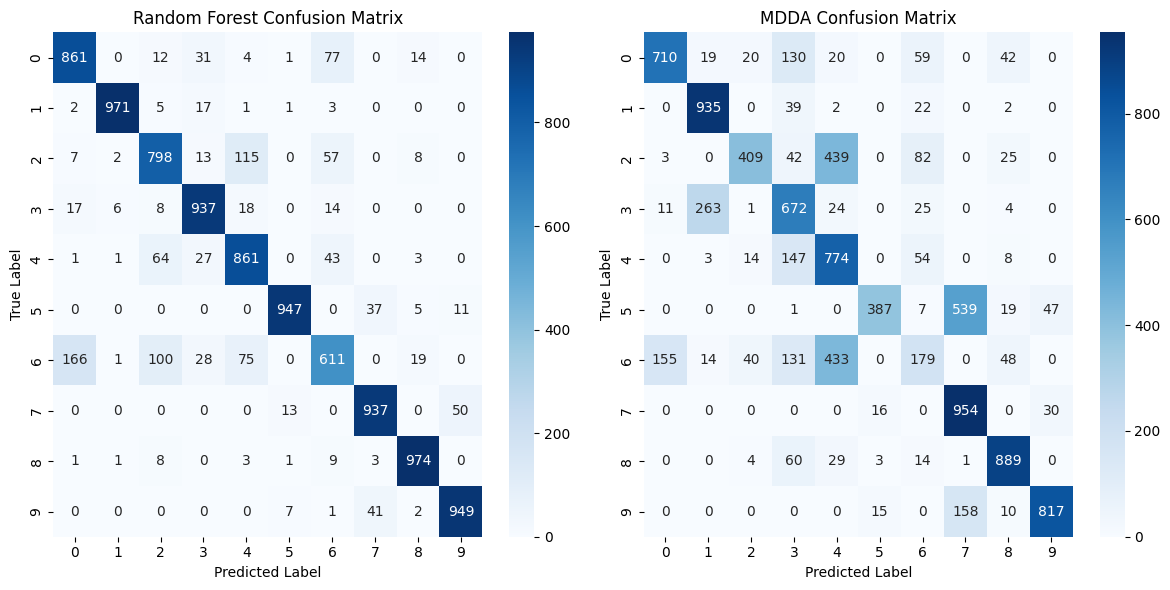

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
#mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
##mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# # MDDA Confusion Matrix
# plt.subplot(1, 2, 2)
# sns.heatmap(mdda_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
# plt.title('MDDA Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

plt.tight_layout()
plt.show()

In [5]:
cost_matrix = np.array([
    [0, 3, 2, 1, 2, 3, 1, 3, 3, 3],
    [3, 0, 3, 3, 3, 3, 3, 3, 3, 3],
    [2, 3, 0, 2, 1, 3, 2, 3, 3, 3],
    [1, 3, 2, 0, 2, 3, 1, 3, 3, 3],
    [2, 3, 1, 2, 0, 3, 2, 3, 3, 3],
    [3, 3, 3, 3, 3, 0, 3, 1, 3, 1],
    [1, 3, 2, 1, 2, 3, 0, 3, 3, 3],
    [3, 3, 3, 3, 3, 1, 3, 0, 3, 1],
    [3, 3, 3, 3, 3, 3, 3, 3, 0, 3],
    [3, 3, 3, 3, 3, 1, 3, 1, 3, 0]
])

conf_matrix = rf_conf_matrix

cost_per_class = np.zeros(len(cost_matrix))
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        cost_per_class[i] += conf_matrix[i, j] * cost_matrix[i, j]

# Average cost per observation
average_cost = np.sum(cost_per_class) / len(y_test)
print("Average Misclassification Cost:", average_cost)

Average Misclassification Cost: 0.1755


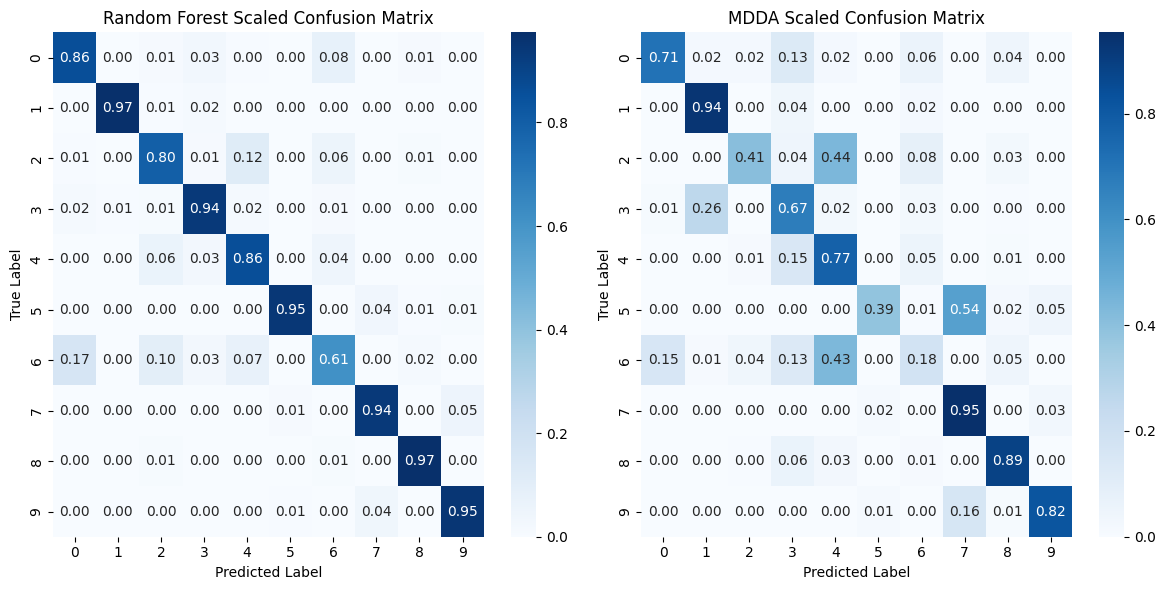

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('Random Forest Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# MDDA Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(mdda_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('MDDA Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report, balanced_accuracy_score

rf_classification_report = classification_report(y_test, rf_predictions)
mdda_classification_report = classification_report(y_test, mdda_predictions)

# Calculate balanced accuracy
rf_balanced_accuracy = balanced_accuracy_score(y_test, rf_predictions)
mdda_balanced_accuracy = balanced_accuracy_score(y_test, mdda_predictions)

# Print results
print("Random Forest Classification Report:")
print(rf_classification_report)
print(f"Balanced Accuracy for Random Forest: {rf_balanced_accuracy:.4f}")

print("\nMDDA Classification Report:")
print(mdda_classification_report)
print(f"Balanced Accuracy for MDDA: {mdda_balanced_accuracy:.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.89      0.94      0.91      1000
           4       0.80      0.86      0.83      1000
           5       0.98      0.95      0.96      1000
           6       0.75      0.61      0.67      1000
           7       0.92      0.94      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Balanced Accuracy for Random Forest: 0.8846

MDDA Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1000
           1       0.7